In this notebook, we will be performing an exploratory data analysis of the algae dataset trying to find the best predictors for the different types of algae we will begin for loding in the essential libraries and loding the data.

**Note: the original analysis.data file contained a few rows with missing commas which was causing troubles with missing values and some other columns being erroneously treated as strings, those were placed manually to avoid loss of data, they could have been handled in software but would have demanded too much computational power and coding for a task that was done with aid of text editing software in a few minutes to restore already available data. The restored dataset will be provided alongside this and the titanic notebook in a zip file**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg

names = ('Season','Size','Speed','max_pH','min_O2','mean_Cl', 'mean_NO3', 'mean_NH4', 'mean_oPO4','mean_PO4', 'mean_Chlor', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7')

algae = pd.read_table('analysis_restored.data', sep=',+', header=None,engine='python',names=names,na_values='XXXXXXX')
algae.isna().sum()

Season 0
Size 0
Speed 0
max_pH 1
min_O2 2
mean_Cl 10
mean_NO3 2
mean_NH4 2
mean_oPO4 2
mean_PO4 2
mean_Chlor 12
a1 0
a2 0
a3 0
a4 0
a5 0
a6 0
a7 0
dtype: int64

As we can see this dataset is dirty, we can use some commands to show us the more problematic row with 6 or more missing values and get rid of them.

In [2]:
algae.loc[algae.isna().sum(axis=1)==6]

,Season,Size,Speed,max_pH,min_O2,mean_Cl,mean_NO3,mean_NH4,mean_oPO4,mean_PO4,mean_Chlor,a1,a2,a3,a4,a5,a6,a7
61,summer,small_,medium,6.4,NaN,NaN,NaN,NaN,NaN,14.0,NaN,19.4,0.0,0.0,2.0,0.0,3.9,1.7
198,winter,large_,medium,8.0,7.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.5,3.7,1.0,0.0,0.0,4.9


In [3]:
algae = algae.loc[algae.isna().sum(axis=1)<6].copy()

This gets rid of the two most problematic rows which barely contained any usable data, however, we cannot repeat this for every single row with few missing values as we would lose too much potentially valuable data so we will handle each of the columns with missing values differently. 

In [4]:
algae.isna().sum()

Season 0
Size 0
Speed 0
max_pH 1
min_O2 1
mean_Cl 8
mean_NO3 0
mean_NH4 0
mean_oPO4 0
mean_PO4 1
mean_Chlor 10
a1 0
a2 0
a3 0
a4 0
a5 0
a6 0
a7 0
dtype: int64

Now the columns max_pH, min_O2 and mean_PO4 only have one missing value to preserve other data present we can just safely replace that value with the mean, which should not alter our observations too much due to low number of values being replaced.

In [5]:
algae["max_pH"].fillna(algae["max_pH"].mean(),inplace=True)

algae["min_O2"].fillna(algae["min_O2"].mean(),inplace=True)

algae["mean_PO4"].fillna(algae["mean_PO4"].mean(),inplace=True)

In [6]:
algae.isna().sum()

Season 0
Size 0
Speed 0
max_pH 0
min_O2 0
mean_Cl 8
mean_NO3 0
mean_NH4 0
mean_oPO4 0
mean_PO4 0
mean_Chlor 10
a1 0
a2 0
a3 0
a4 0
a5 0
a6 0
a7 0
dtype: int64

Now the only remaining columns with missing data are mean_Chlor and mean_Cl. We will handle those in a different way than those above, namely using pandas fillna function with the ffill method, this replaces the missing values with the last valid value observed this has some problems, primarily the fact that it assumes that the data is distributed at random, but for a relatively low number of missing values it should not skew our observations too much and is computationally cheap and fast.

In [7]:
algae["mean_Chlor"].fillna(method="ffill",inplace=True)

algae["mean_Cl"].fillna(method="ffill",inplace=True)

In [8]:
algae.isna().sum()

Season 0
Size 0
Speed 0
max_pH 0
min_O2 0
mean_Cl 0
mean_NO3 0
mean_NH4 0
mean_oPO4 0
mean_PO4 0
mean_Chlor 0
a1 0
a2 0
a3 0
a4 0
a5 0
a6 0
a7 0
dtype: int64

We now have a perfectly clean dataset to start exploring, but first we can change some columns to an ordered categorical value, this should aid us later.

In [9]:
algae.Season = pd.Categorical(algae.Season, categories=['spring', 'summer', 'autumn', 'winter'], ordered=True)
algae.Size = pd.Categorical(algae.Size, categories=['small_', 'medium', 'large_'], ordered=True)
algae.Speed = pd.Categorical(algae.Speed, categories=['low___', 'medium', 'high__'], ordered=True)

Perfect, we will now begin with an overview of each feature separately and then proceed to linking them to our targets, starting with Season

<Axes: xlabel='Season', ylabel='count'>

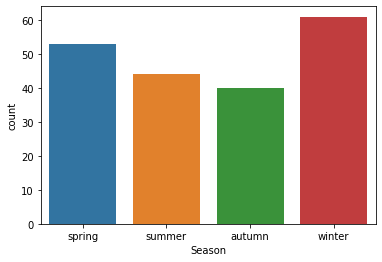

In [10]:
sns.countplot(data=algae,x="Season")

There is not much to discuss in realation to Season, it is a simple categorical variable with a relatively even distribution with maybe slightly too little autumn entries and maybe slightly too many for winter, but not enough to be a problem.

Now to take a look at Size.

<Axes: xlabel='Size', ylabel='count'>

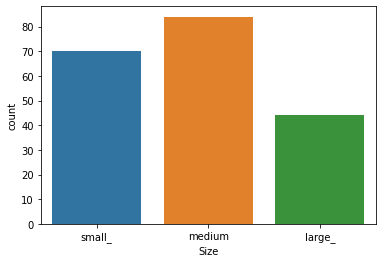

In [11]:
sns.countplot(data=algae,x="Size")

Size follows the same trend of Season being overall even but a slight overrepresentation of a category but again it should not be a problem.

And to the last categorical variable, Speed.

<Axes: xlabel='Speed', ylabel='count'>

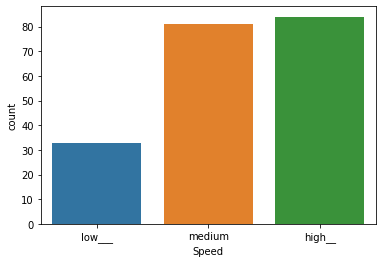

In [12]:
sns.countplot(data=algae,x="Speed")

Speed has a bit more of a skewed distribution, with high and medium being even and low having very few observations. But as just the data scientist, there is not a lot we can do about this than to recommend that more data about slow rivers be collected.

Now to the more interesting numerical features.

In [13]:
def numVisualization (feature : str):
    fig, axes = plt.subplots(1,2, figsize=(25, 10))
    sns.histplot(data=algae,x=feature,ax=axes[0])
    sns.violinplot(data=algae,x=feature,ax=axes[1])

This is a generic function that will receive the desired feature as a string and create standard visualizations for us, which after, if desired, we can do further visualizations as needed.

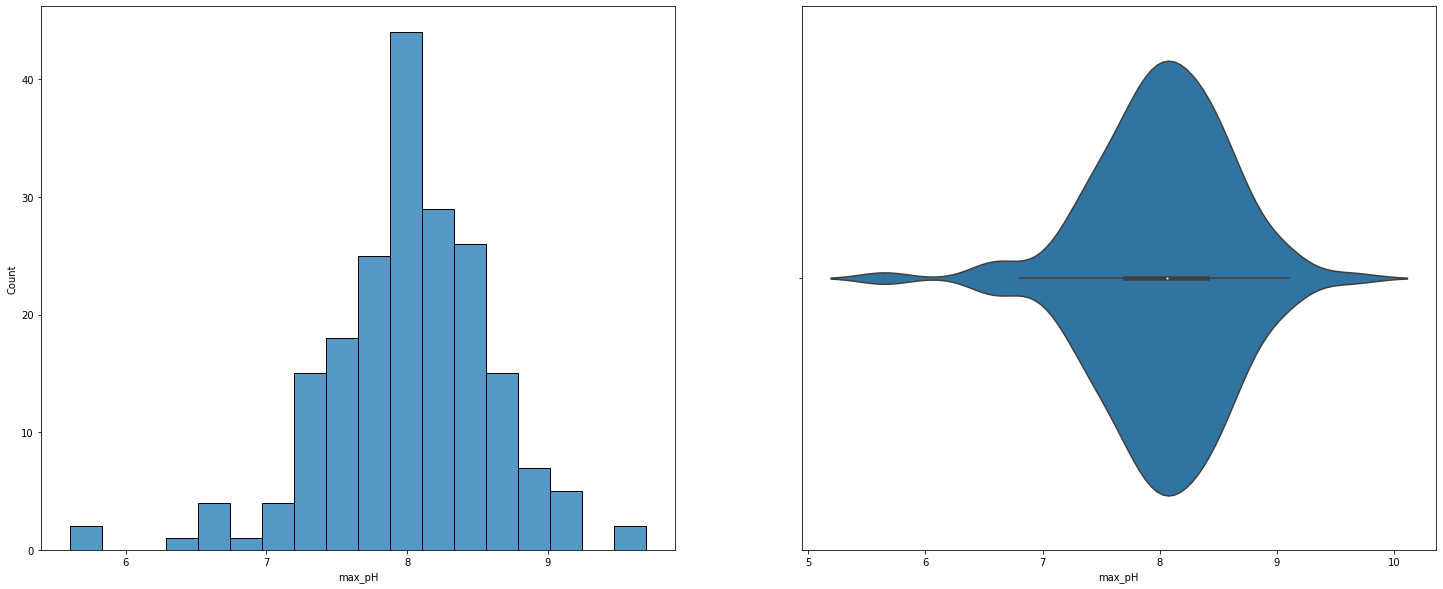

In [14]:
numVisualization("max_pH")

The max pH data is overall ok, following something close to a normal distribution, we will check how close it is to one with a qq plot later, there are some outliers, but they are not very extreme, thus not altering out visualisations too much and they could reveal something interesting, maybe some algae thrive in extremely basic or acidic conditions! So I elect to keep them as is for now.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

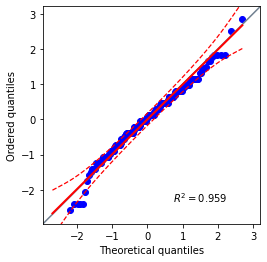

In [15]:
pg.qqplot(algae["max_pH"])

As expected the values fall pretty close to a normal distribution, even most of the outliers, this data is overall very good!

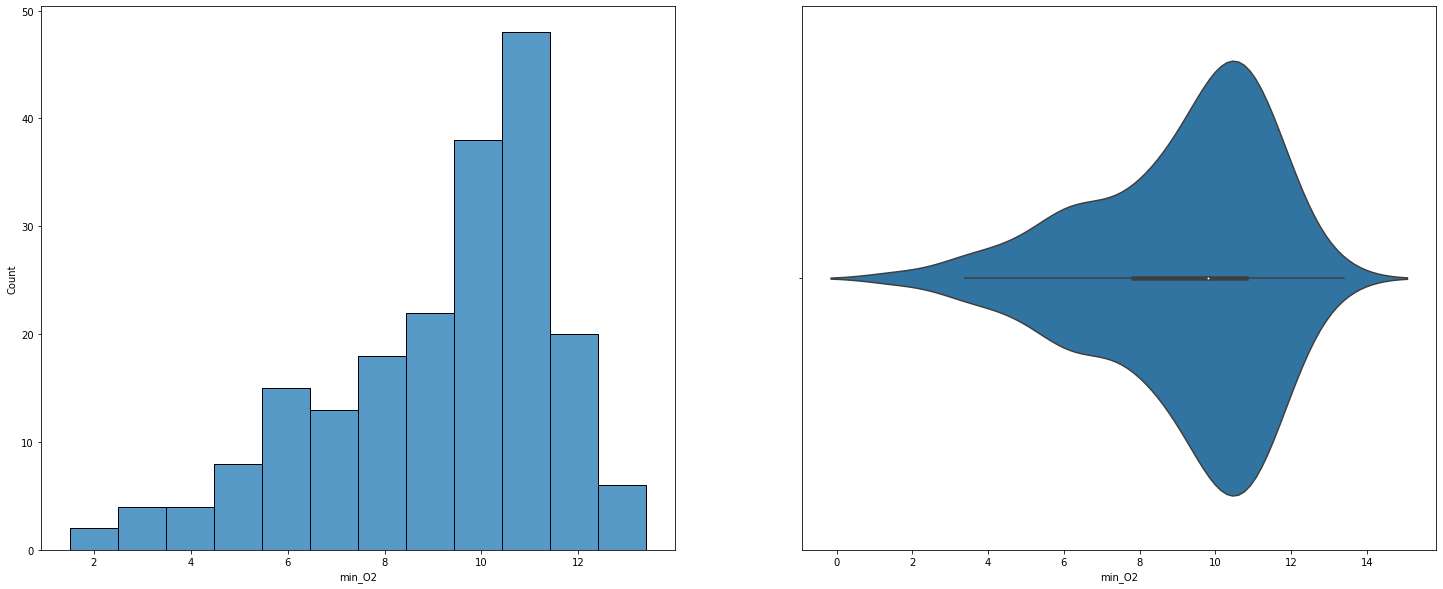

In [16]:
numVisualization("min_O2")

The min O2 data is also good. It does not seem to follow a normal distribution but something more eccentric, akin to a reversed Weibull distribution, where instead of "trailing off" after the peak, the data "piles up" until reaching it. There does not seem to be any real outliers, and this data should again prove itself valuable to us.

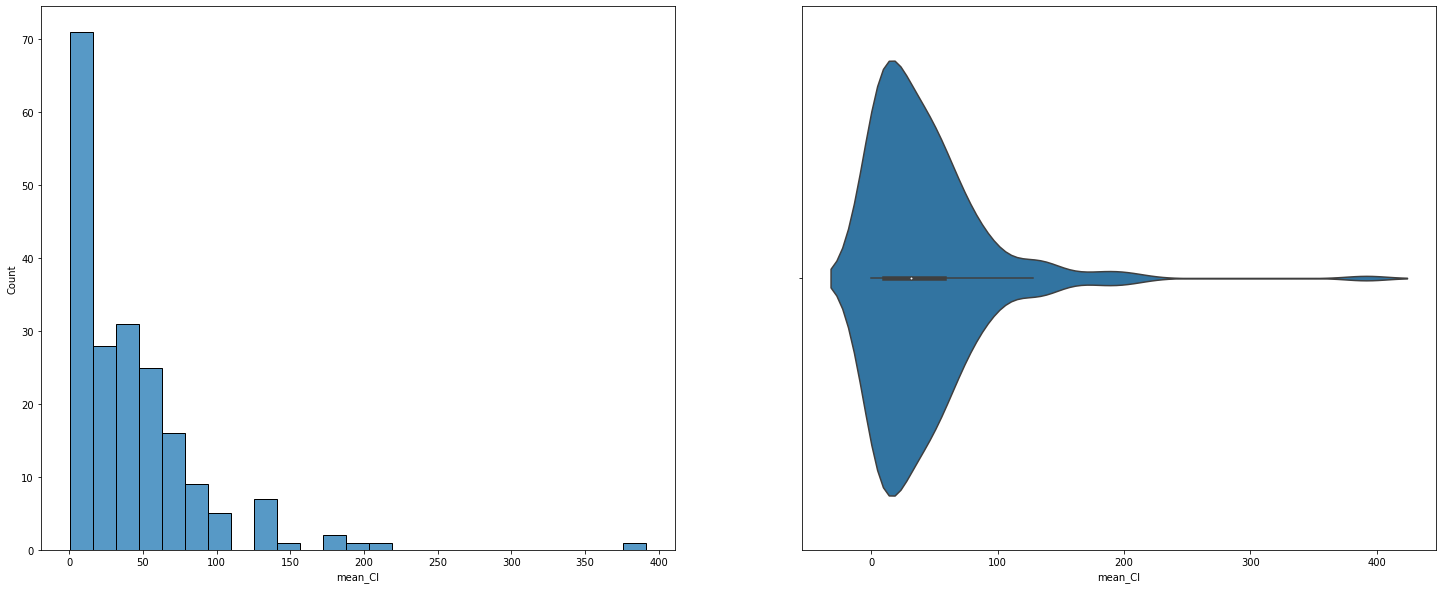

In [17]:
numVisualization("mean_Cl")

Now this data is a bit more problematic, following something close to an exponential distribution but with a few outliers that can mess up our observations, expecially the one all the way over 350, so we will clip any values above 175 and replace them 175, this should still keep them as observations in the upper boundries preserving the original relationship with the targets, but making our visualizations clearer.

In [18]:
algae["mean_Cl"].clip(upper=175,inplace=True)#takes any value above the upper boundary and replaces it with the boundary

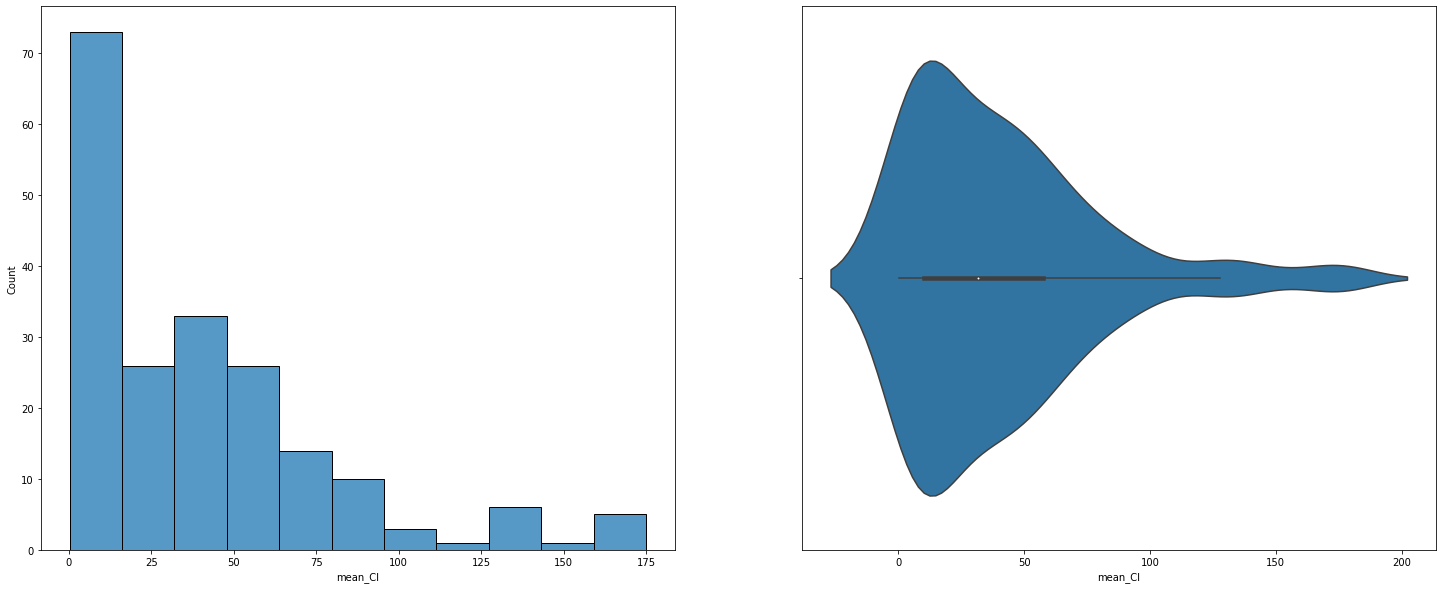

In [19]:
numVisualization("mean_Cl")

Now it looks much cleaner and will hopefully provide us with better insights.

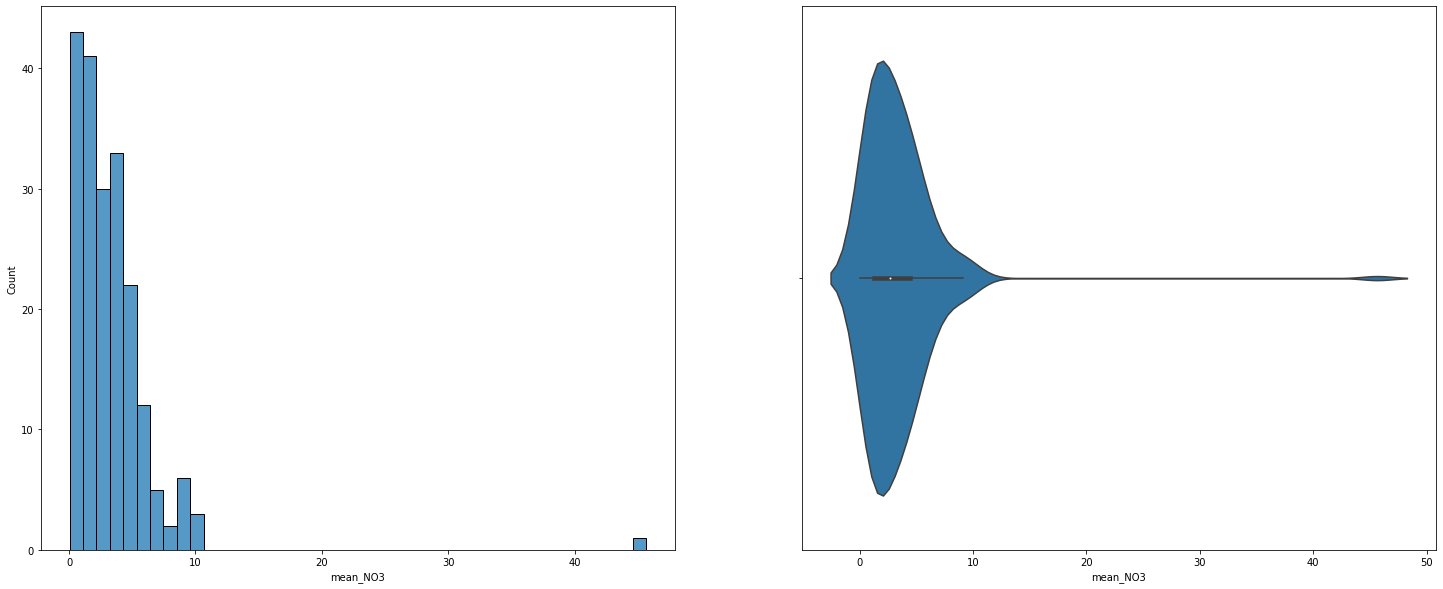

In [20]:
numVisualization("mean_NO3")

This data has one clear outlier this could mean that some equipment is at fault, giving us a false reading, so we will handle it in a different way, by replacing it with the mean for the column which will hopefully represent the true value better

In [21]:
algae["mean_NO3"].where(algae.mean_NO3 <= 20, other= algae["mean_NO3"].mean() ,inplace = True)
#replaces any value for wich the condition is true with the value of other

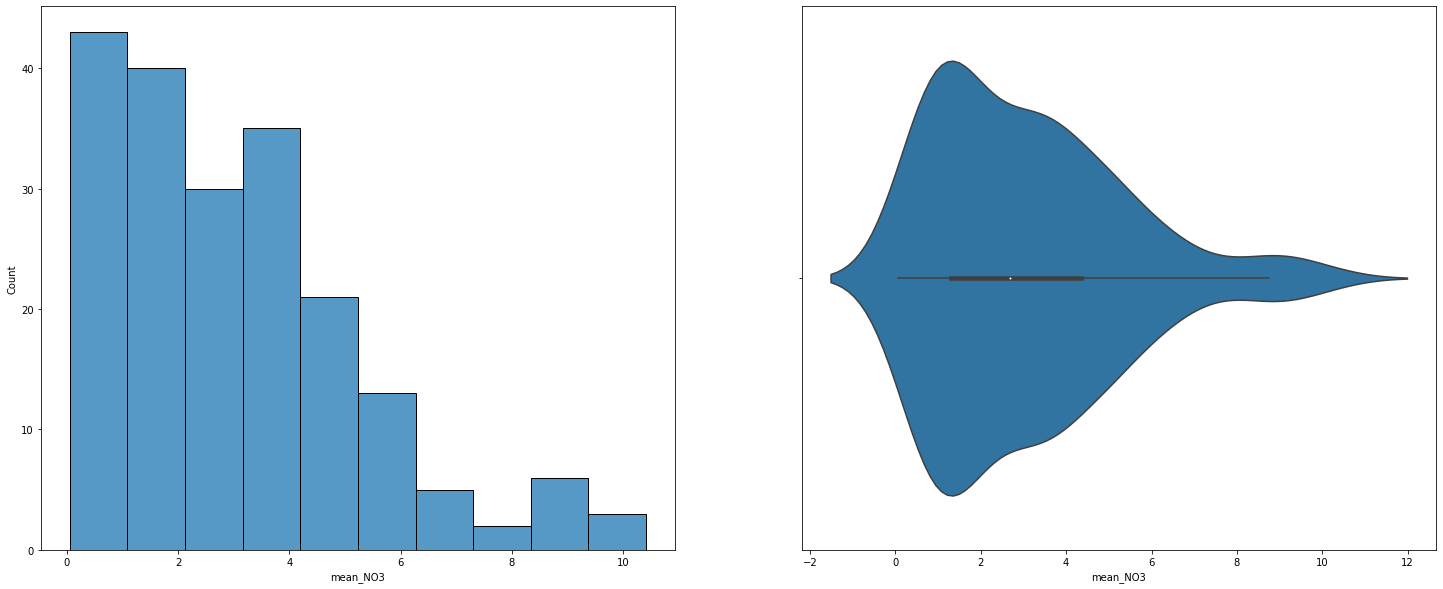

In [22]:
numVisualization("mean_NO3")

With the improved data, we can now see that the data follows an almost linear distribution, instead of the more exponential look that the previous graph with the outlier gave us

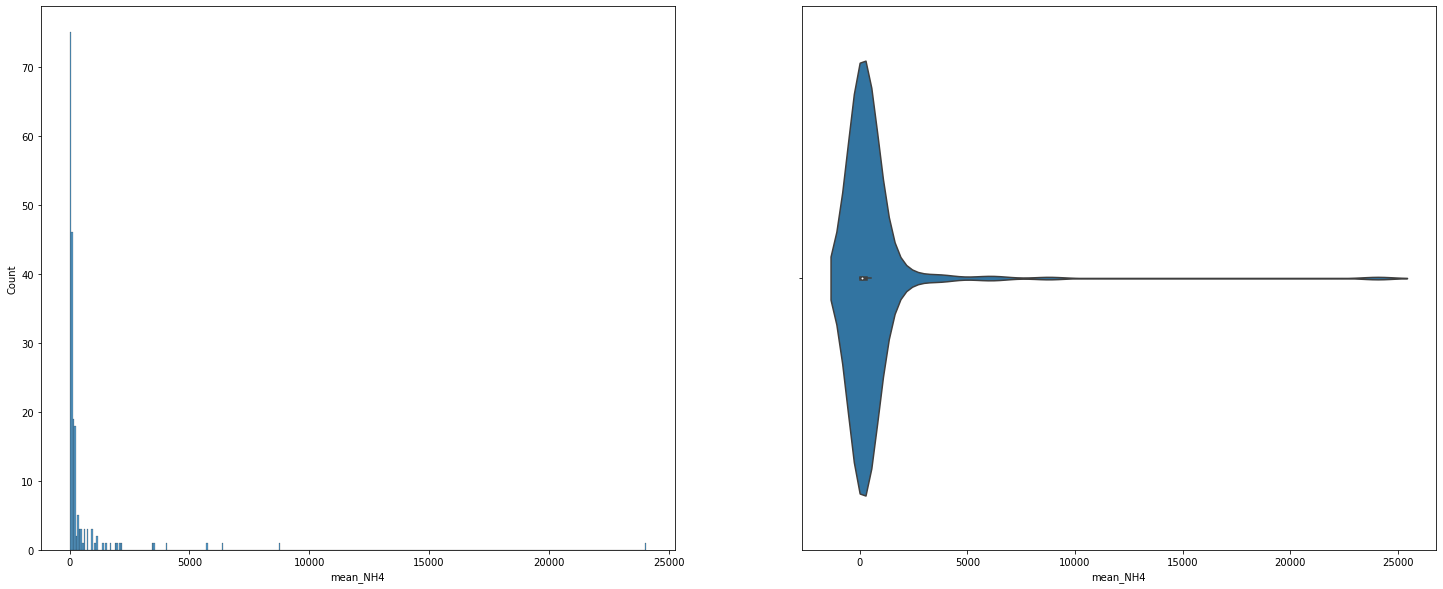

In [23]:
numVisualization("mean_NH4")

This data is extremely messy, with lots of outliers and a few extreme outliers, we will handle them in differnt ways, the extreme outliers (>5000) will be handled as invalid data and will be set to the mean, but the ones close to normal values (>2500) will just be set to the threshold as they are more likely to be valid readings and thus are better represented that way.

In [24]:
algae["mean_NH4"].where(algae.mean_NH4 <= 5000, other= algae["mean_NH4"].mean() ,inplace = True)
algae["mean_NH4"].clip(upper=2500,inplace=True)

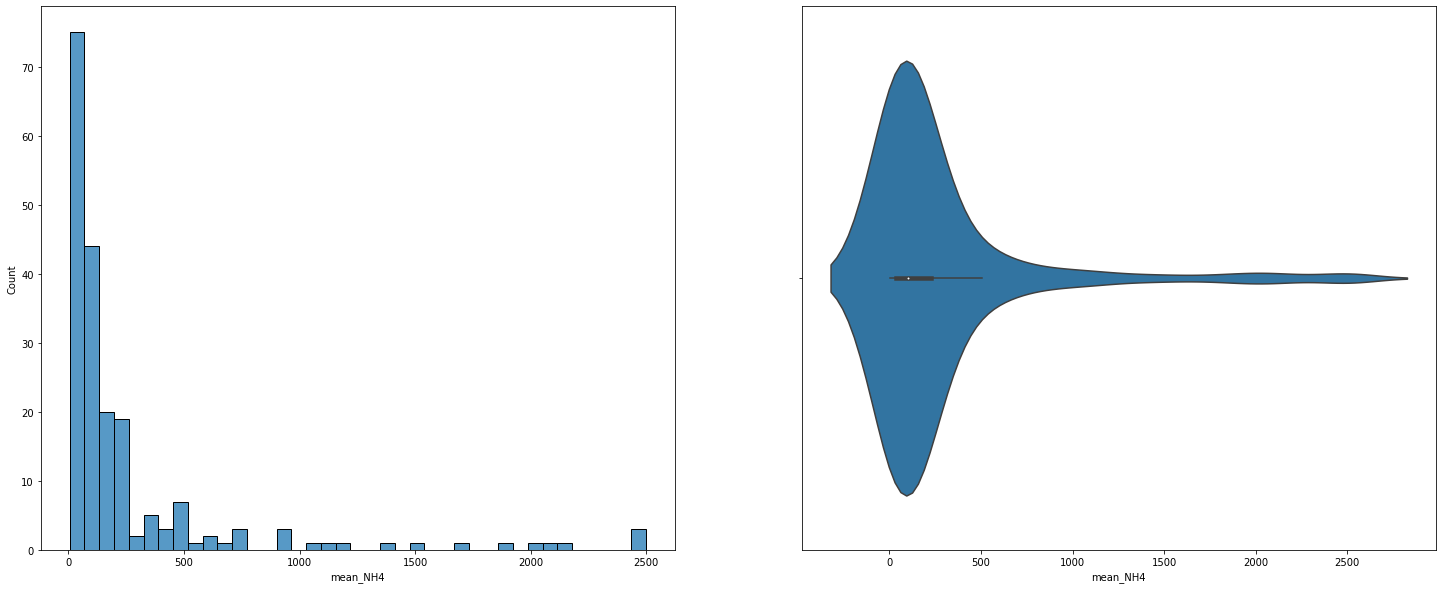

In [25]:
numVisualization("mean_NH4")

Now the data falls closer to an exponential distribution, we could clip the outliers at a lower value, but I believe that would lose the richness of the data, so I prefer to keep it that way.

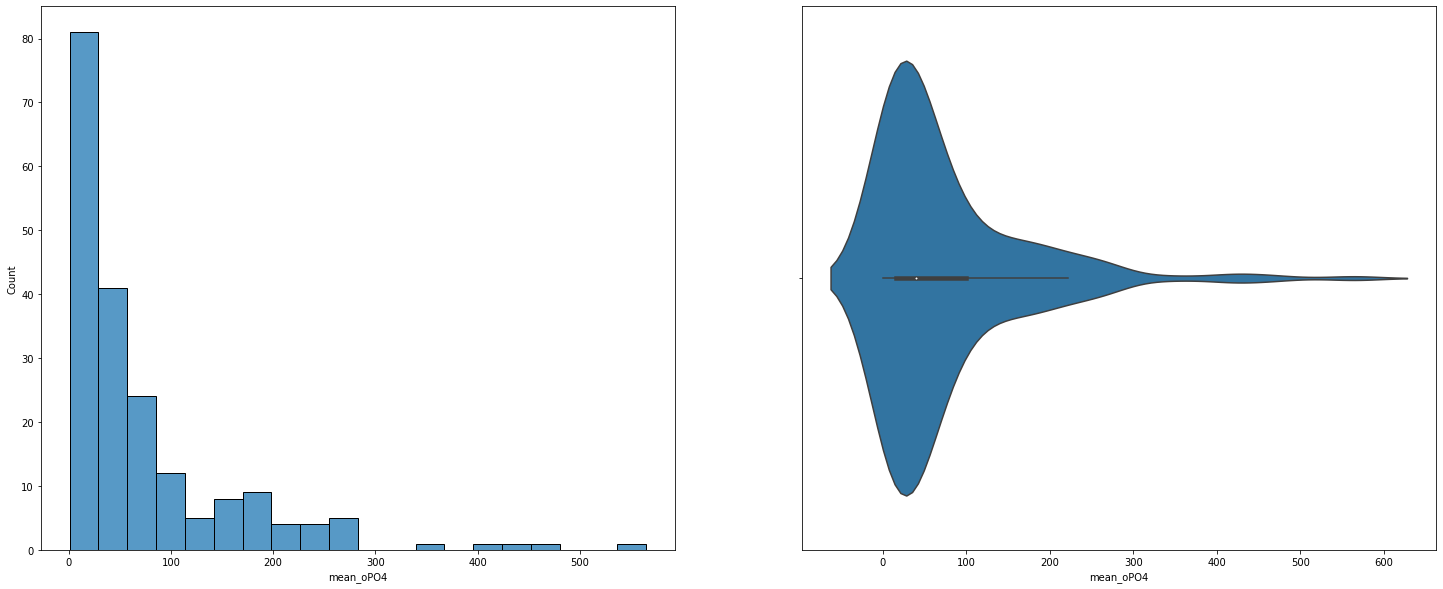

In [26]:
numVisualization("mean_oPO4")

This feature appears to have some outliers at values above 300, as they are not too outside the boundries of realistic values they are more likely to be true readings, it is better to just set them to the threshold as to better represent their relationship with the target.

In [27]:
algae["mean_oPO4"].clip(upper=300,inplace=True)

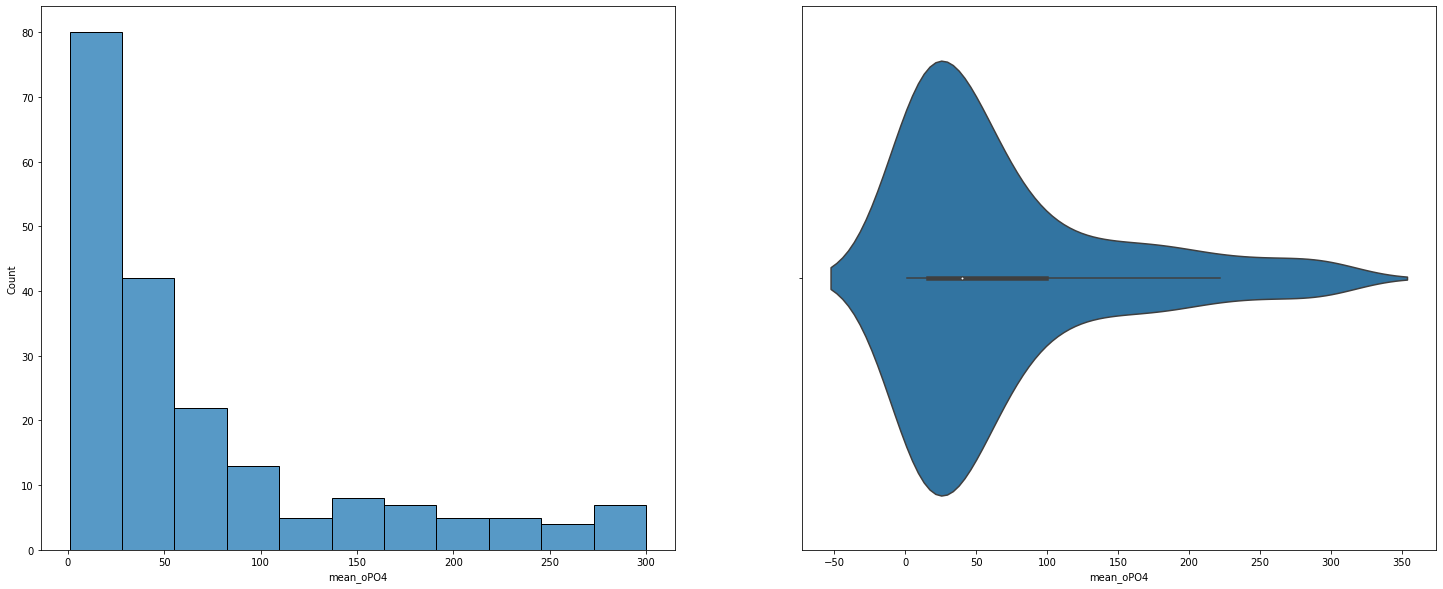

In [28]:
numVisualization("mean_oPO4")

Now the data looks cleaner and will be of more use to us.

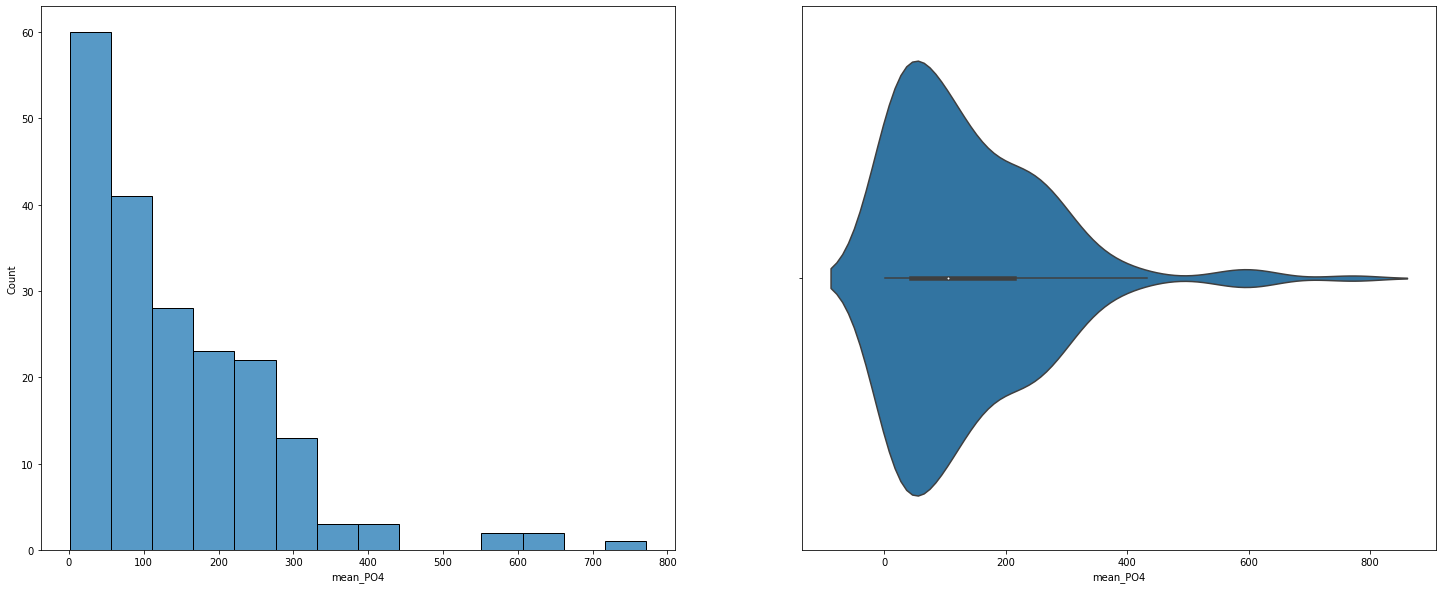

In [29]:
numVisualization("mean_PO4")

This feature behaves similarly to mean oPO4, so we will deal with the outliers in the same way, but with a threshold of 500.

In [30]:
algae["mean_PO4"].clip(upper=500,inplace=True)

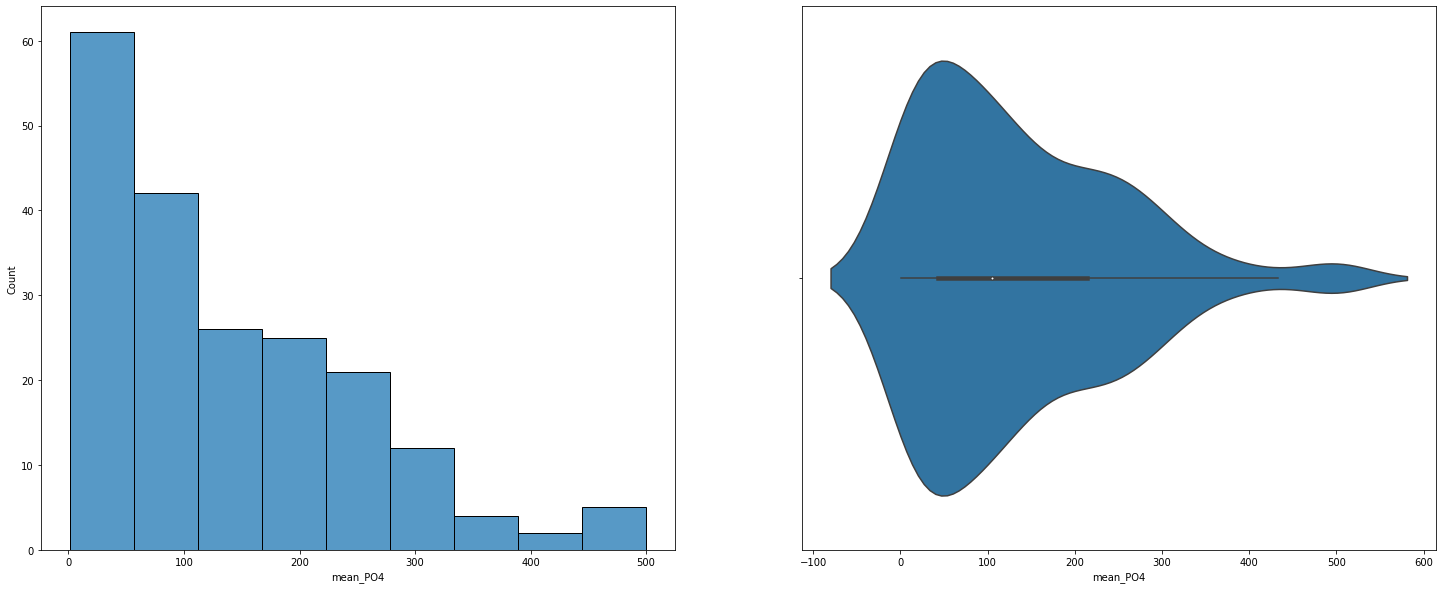

In [31]:
numVisualization("mean_PO4")

Now the Feature will be more digestible in out visualizations and still retain the original relationships.

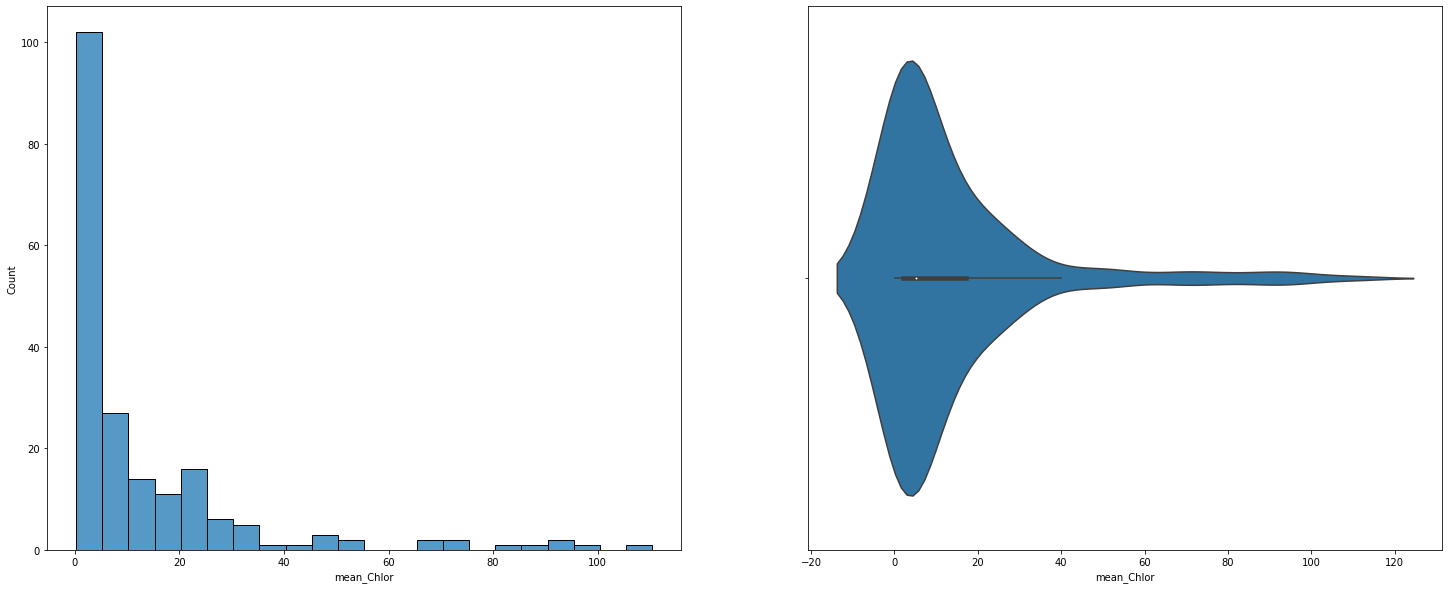

In [32]:
numVisualization("mean_Chlor")

For this Feature, the outliers are also not very extreme, thus being more likely to be real readings, so we will just use the clipping technique with a boundary of 60.

In [33]:
algae["mean_Chlor"].clip(upper=60,inplace=True)

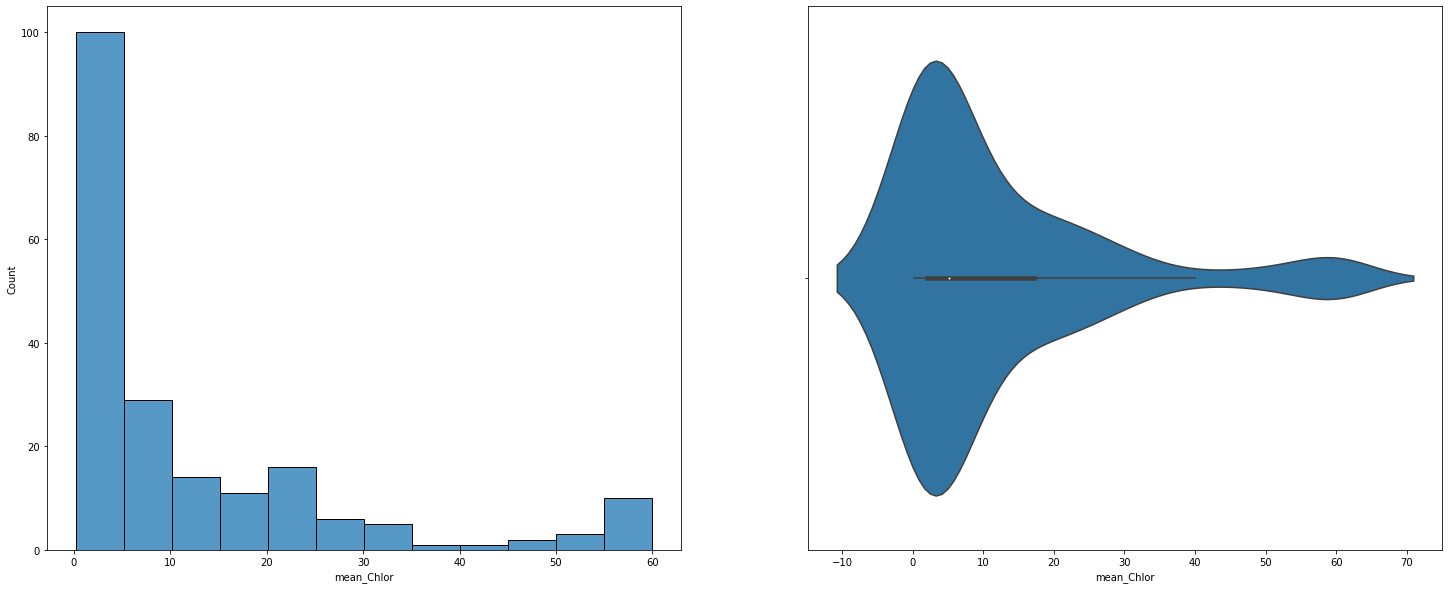

In [34]:
numVisualization("mean_Chlor")

Now we will proceed to visualize the relationships between the various features and our targets.

First, to avoid repeated lines of code we will create a general visualization function.

In [35]:
def viewRelations(target : str):
    fig, axes = plt.subplots(4,3, figsize=(25, 15))
    sns.boxplot(algae,x=target,y="Season",ax=axes[0,0])
    sns.boxplot(algae,x=target,y="Size",ax=axes[0,1])
    sns.boxplot(algae,x=target,y="Speed",ax=axes[0,2])
    sns.scatterplot(x="max_pH", y=target, data=algae,ax=axes[1,0])
    sns.scatterplot(x="min_O2", y=target, data=algae,ax=axes[1,1])
    sns.scatterplot(x="mean_Cl", y=target, data=algae,ax=axes[1,2])
    sns.scatterplot(x="mean_Chlor", y=target, data=algae,ax=axes[2,0])
    sns.scatterplot(x="mean_NO3", y=target, data=algae,ax=axes[2,1])
    sns.scatterplot(x="mean_NH4", y=target, data=algae,ax=axes[2,2])
    sns.scatterplot(x="mean_oPO4", y=target, data=algae,ax=axes[3,0])
    sns.scatterplot(x="mean_PO4", y=target, data=algae,ax=axes[3,1])

This function takes in a string with the desired target column and generates several standard visualizations at the same time, afterwards we can generate further graphs as needed.

We will start by taking a look at target a1.

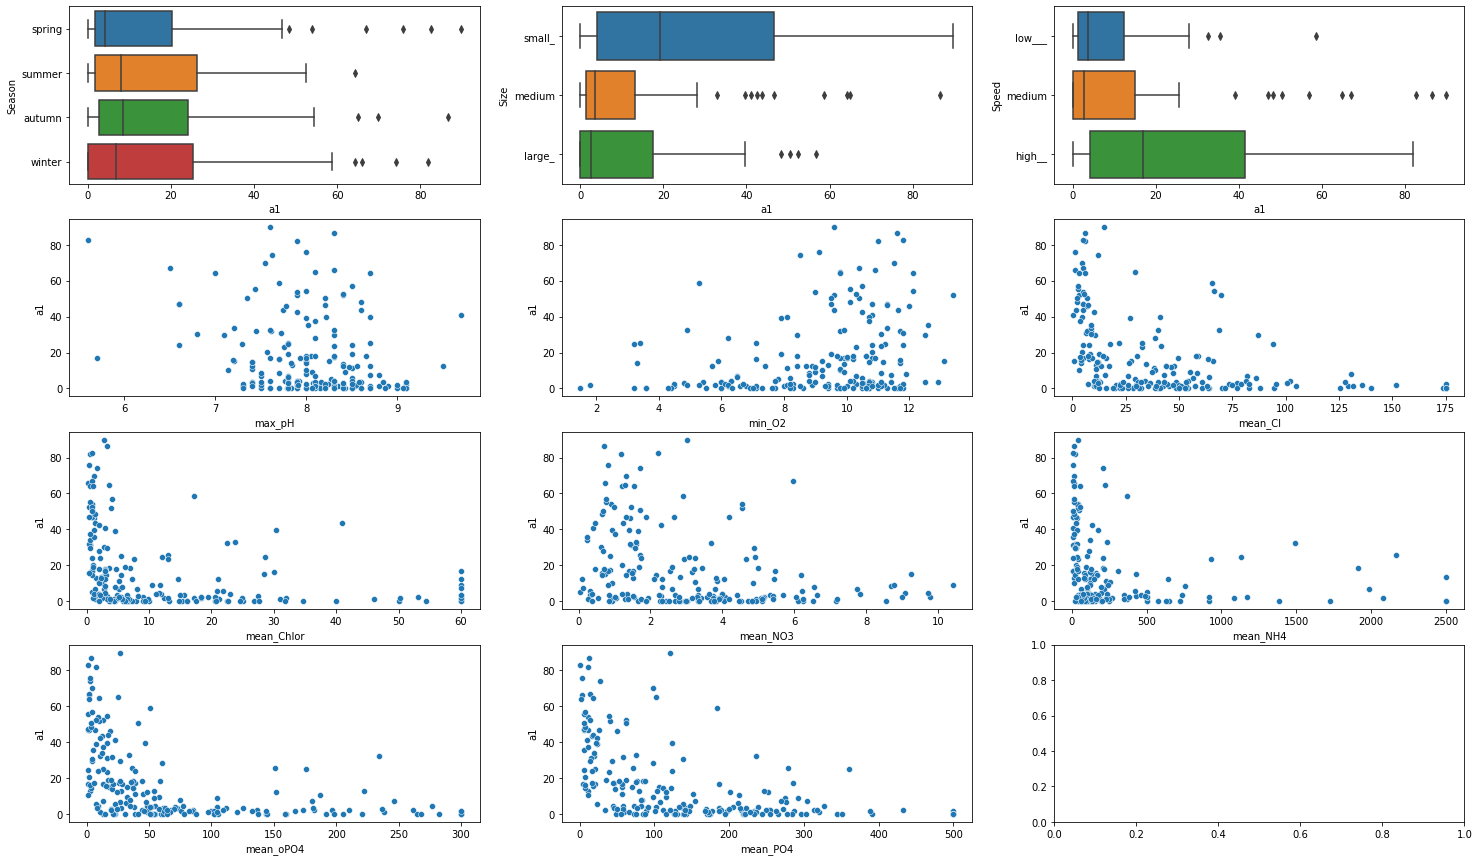

In [36]:
viewRelations("a1")

From the visualisations it seems like the best predictors for a1 would be, size, speed, mean Cl, mean Chlor, mean NH4, mean oPO4 and mean PO4, with mean NO3 also having a weaker relationship to the target.

We will further confirm our suspicions later with the correlation matrices.

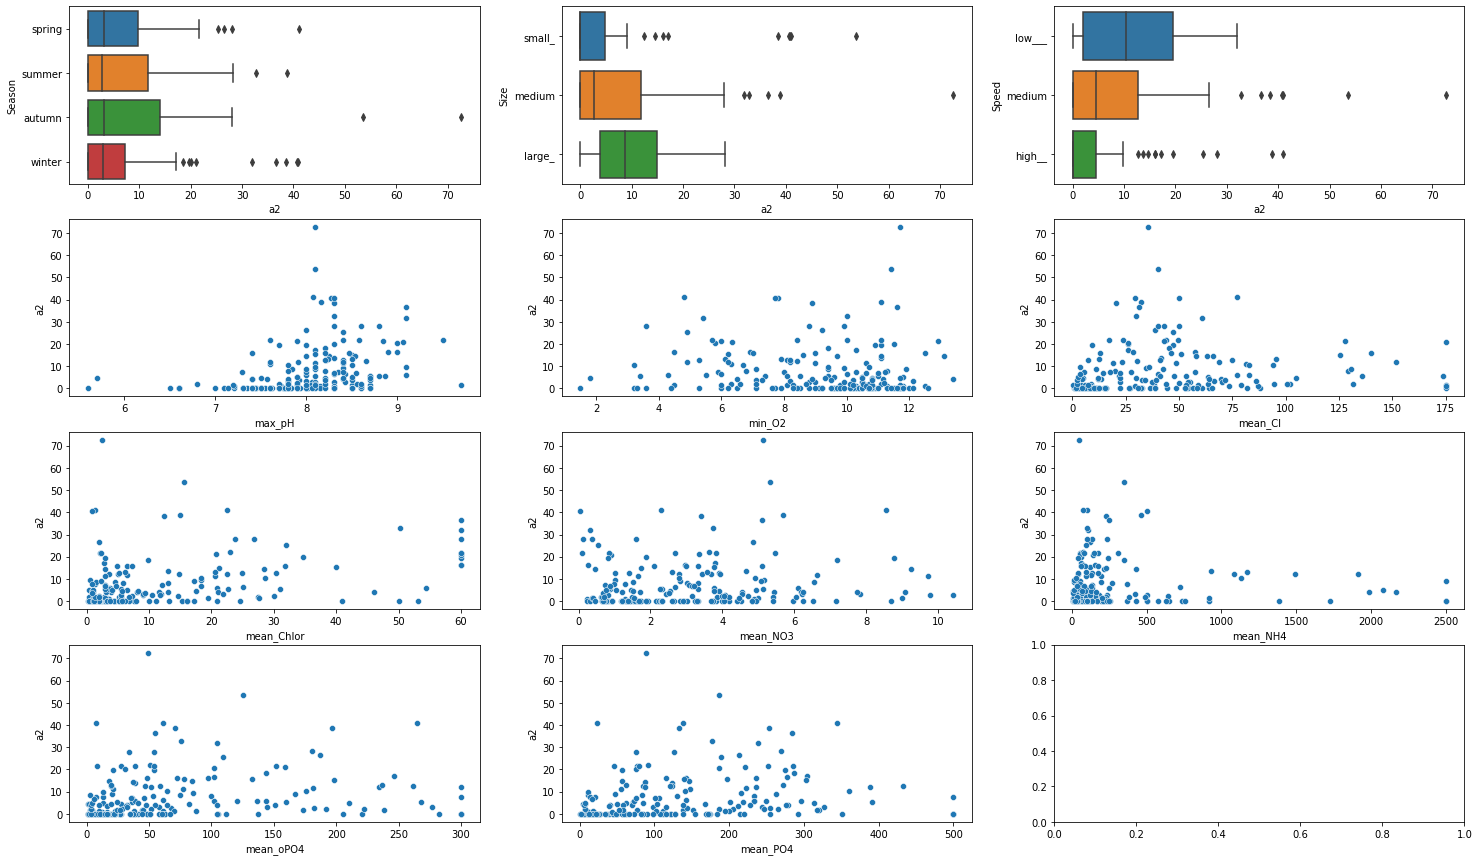

In [37]:
viewRelations("a2")

With a2, most relationships are not as strong as with a1, but it seems the best predictors would be mean NH4, max pH, speed, mean Chlor and size. Min O2, mean Cl, mean NO3 and season also look like they might have some relationship with the target, but considerably weaker.

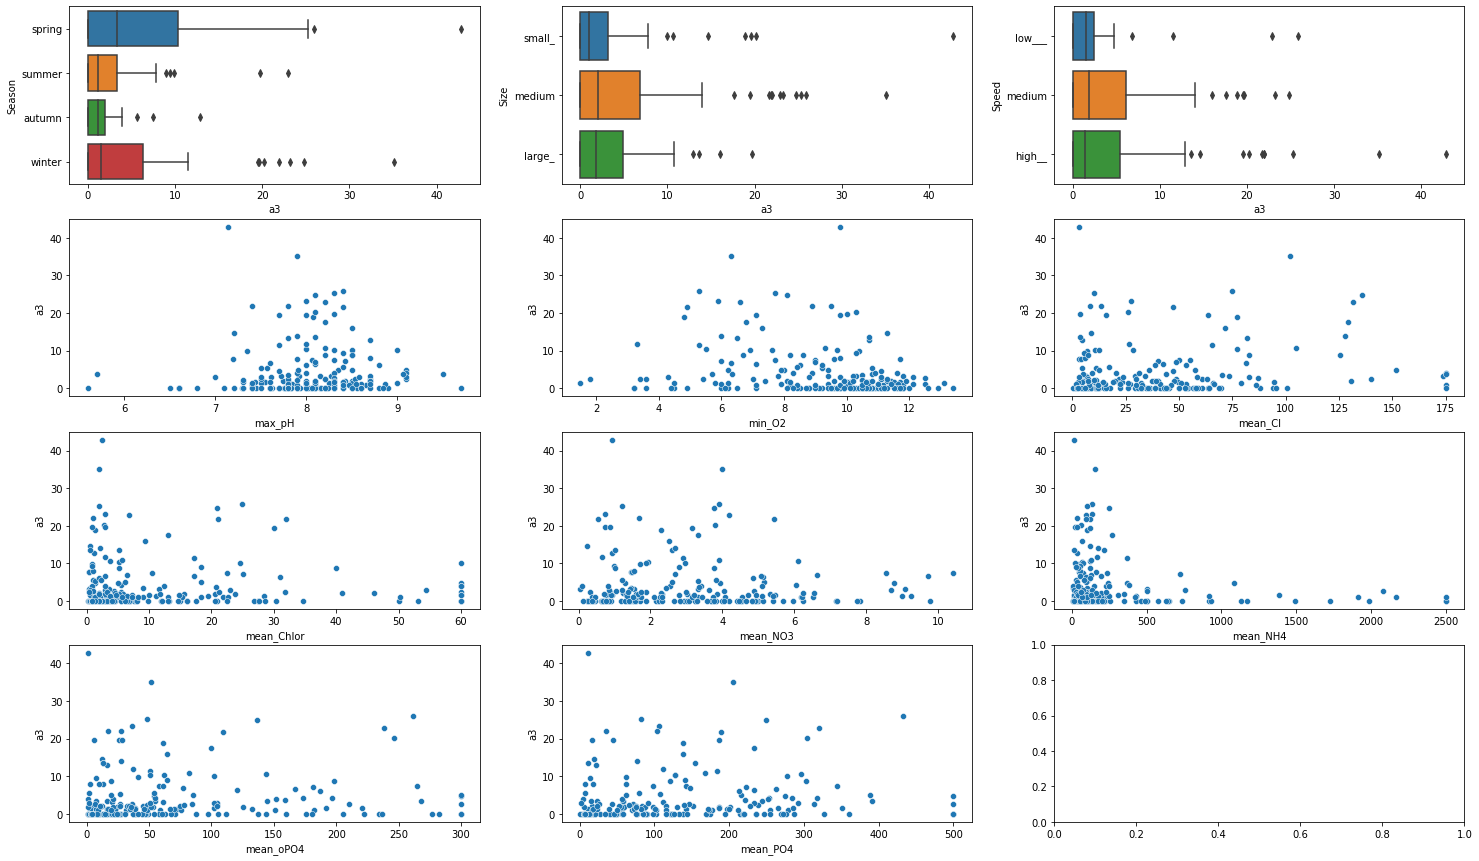

In [38]:
viewRelations("a3")

With a3 it seems the best predictors would be max pH, min O2, mean NH4 and season. With mean oPO4, mean PO4, mean Chlor, size and speed also possibly having some weaker relation to the target.

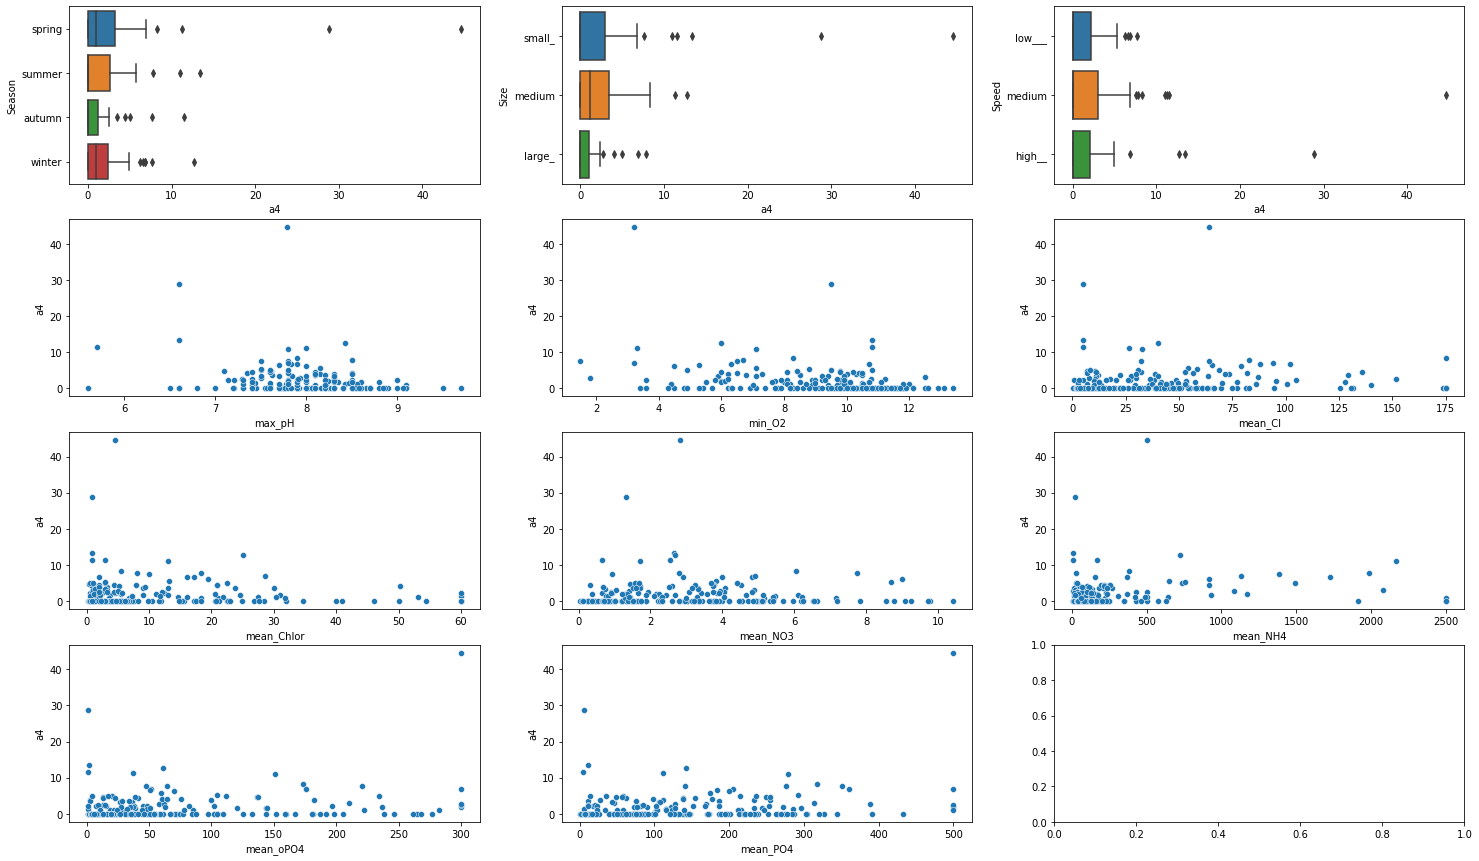

In [39]:
viewRelations("a4")

A4 seems overall pretty tricky to predict with overall low populations except for some outliers, but it seems that max pH, min O2, size and mean Chlor would be good indicators.

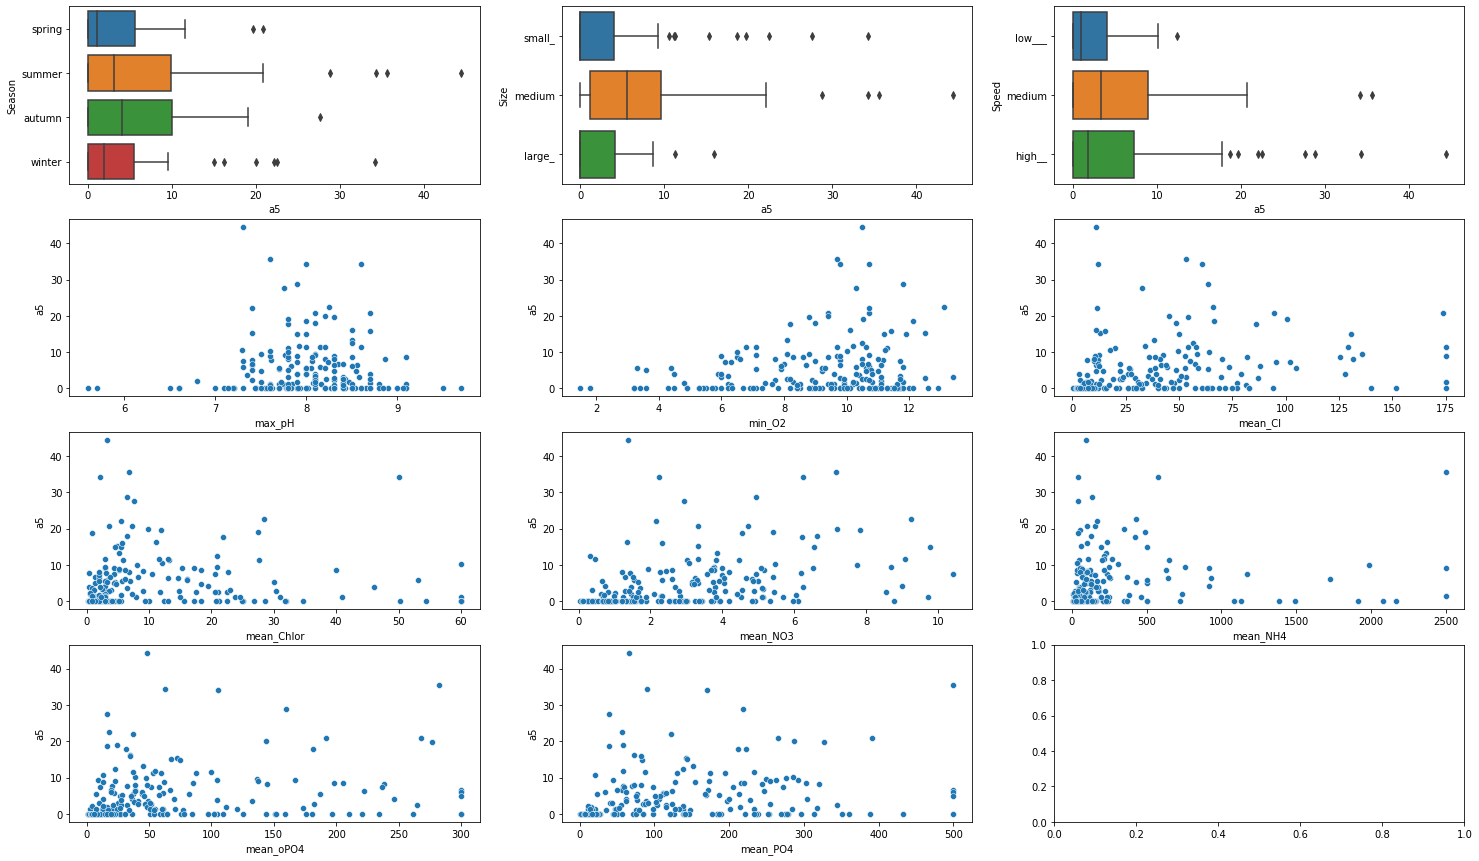

In [40]:
viewRelations("a5")

With a5 the best indicators seem to be season, size, speed, min O2, max pH, mean NH4 and mean Chlor. Another possible indicator to a lower degree could be mean Cl. 

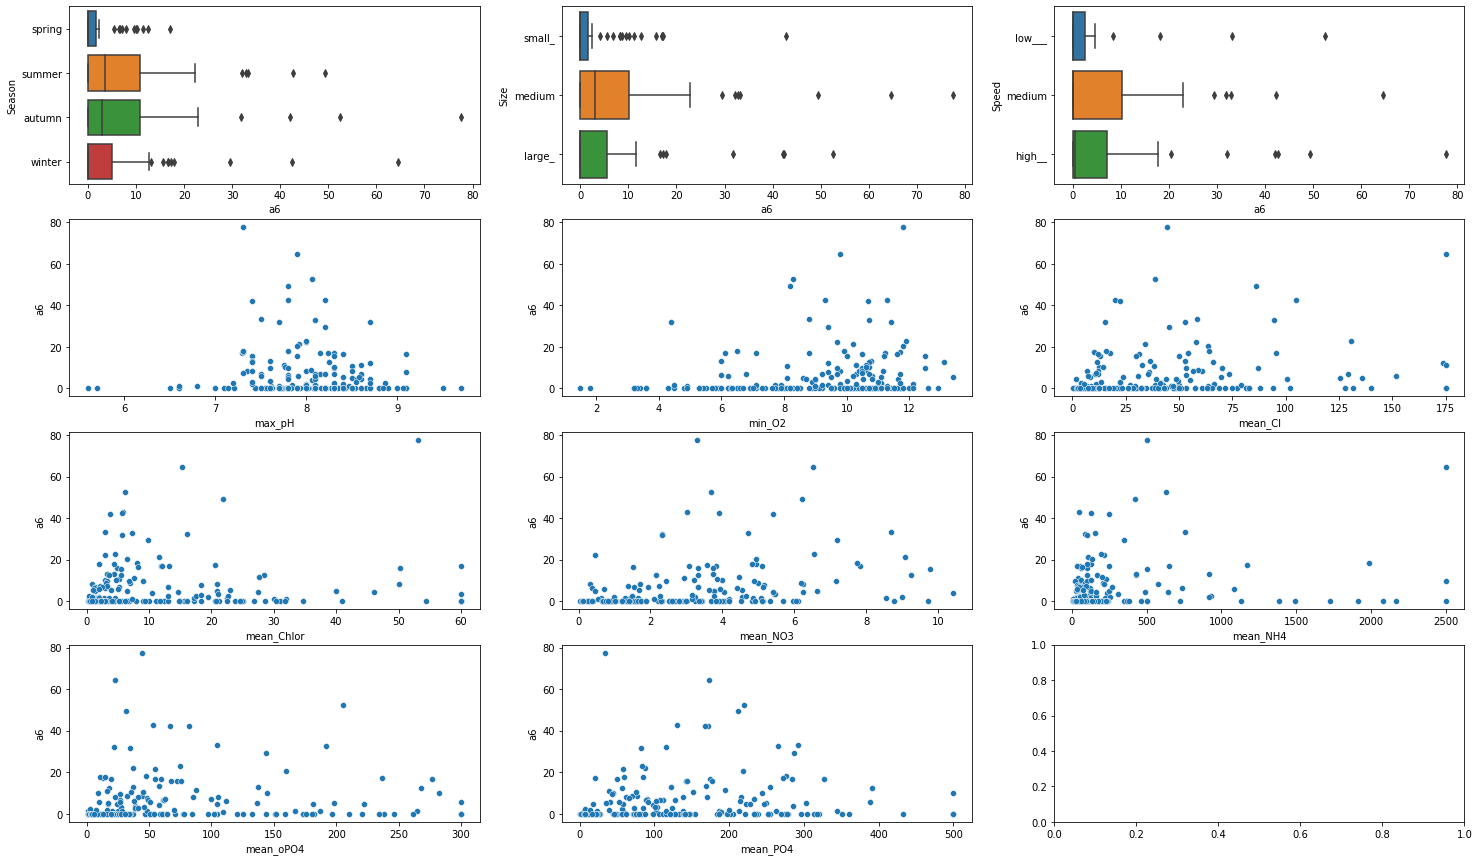

In [41]:
viewRelations("a6")

For a6 it seems that season, size, speed, max pH, min O2 and mean PO4 are the most important features. With mean NH4, mean Chlor and mean Cl also seeming to have some impact.

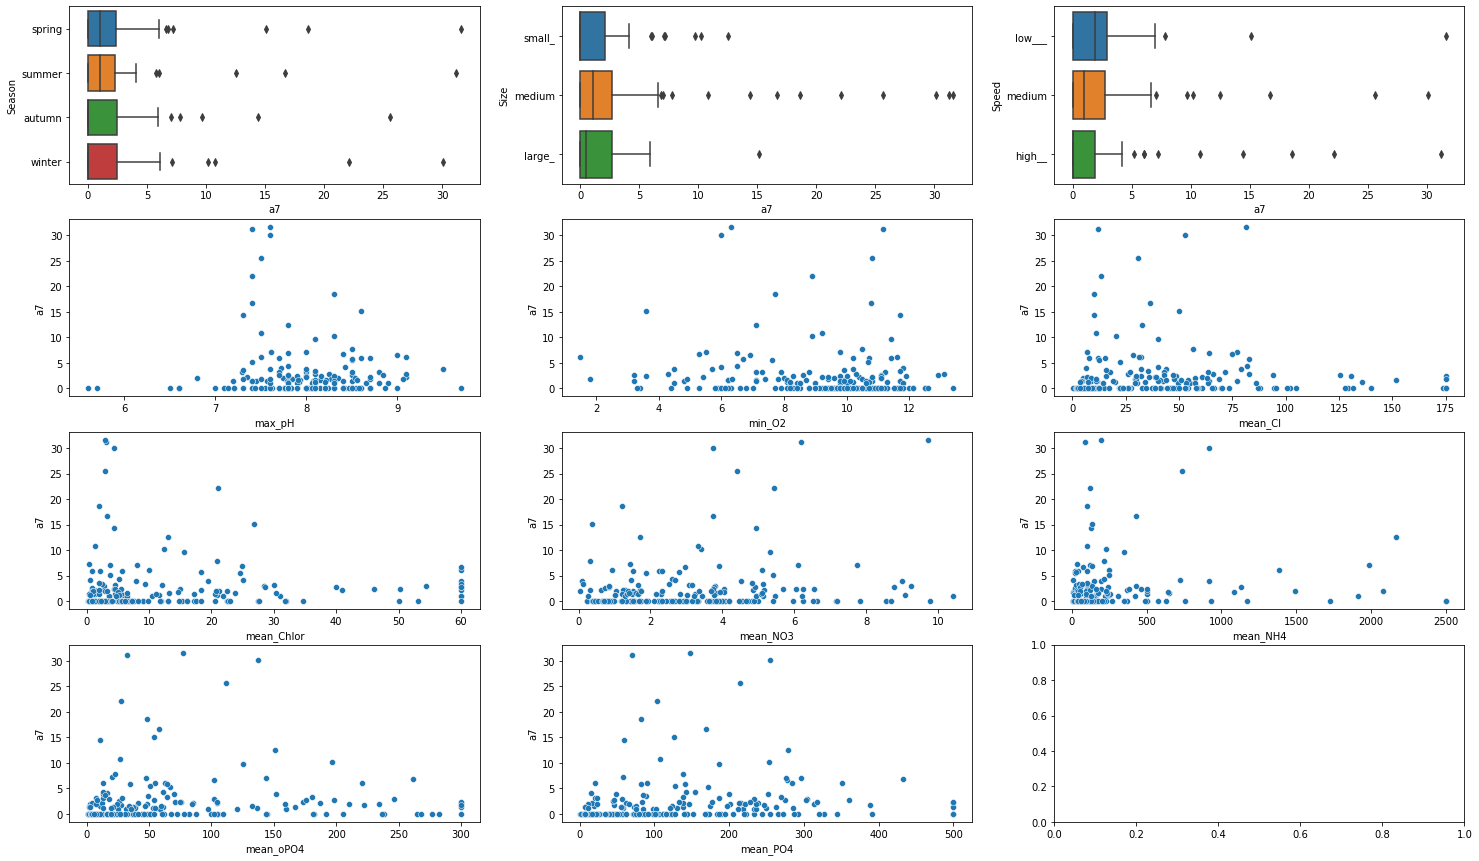

In [42]:
viewRelations("a7")

For a7 the most important features seem to be max pH, min O2, mean Cl, mean Chlor, mean NO3 and mean NH4. With mean oPO4 and mean PO4 also potentially having some realtion to the target.

We will now generate some correlation matrices to try and see if they correlate to our earlier visualizations and observations.

In [43]:
columns = algae.columns
corr = algae[columns].corr(numeric_only=True,method ="pearson")
corr

,max_pH,min_O2,mean_Cl,mean_NO3,mean_NH4,mean_oPO4,mean_PO4,mean_Chlor,a1,a2,a3,a4,a5,a6,a7
max_pH,1.000000,-0.167980,0.226462,-0.102153,-0.043217,0.195995,0.206293,0.406965,-0.268539,0.326085,0.030987,-0.248611,-0.016745,-0.083711,-0.087096
min_O2,-0.167980,1.000000,-0.333851,0.059467,-0.273641,-0.429032,-0.497881,-0.178883,0.280021,-0.098409,-0.250715,-0.314556,0.171100,0.159416,-0.120507
mean_Cl,0.226462,-0.333851,1.000000,0.395533,0.278793,0.491772,0.556089,0.255197,-0.432756,0.136389,0.129265,0.073480,0.220601,0.229075,-0.016456
mean_NO3,-0.102153,0.059467,0.395533,1.000000,0.265221,0.316930,0.384436,0.108311,-0.337455,0.103867,-0.068259,-0.025997,0.363826,0.331398,0.187947
mean_NH4,-0.043217,-0.273641,0.278793,0.265221,1.000000,0.370766,0.427269,0.037640,-0.204669,-0.028090,-0.164574,0.178403,0.124655,0.194115,0.097977
mean_oPO4,0.195995,-0.429032,0.491772,0.316930,0.370766,1.000000,0.901315,0.195842,-0.455111,0.196809,0.058266,0.168969,0.189265,0.056570,0.067284
mean_PO4,0.206293,-0.497881,0.556089,0.384436,0.427269,0.901315,1.000000,0.330117,-0.514599,0.195824,0.085789,0.218854,0.195360,0.101066,0.124798
mean_Chlor,0.406965,-0.178883,0.255197,0.108311,0.037640,0.195842,0.330117,1.000000,-0.331315,0.384109,-0.046086,-0.085698,-0.020283,0.056325,0.019351
a1,-0.268539,0.280021,-0.432756,-0.337455,-0.204669,-0.455111,-0.514599,-0.331315,1.000000,-0.292520,-0.146950,-0.038924,-0.295033,-0.276026,-0.211425
a2,0.326085,-0.098409,0.136389,0.103867,-0.028090,0.196809,0.195824,0.384109,-0.292520,1.000000,0.030311,-0.171682,-0.161862,-0.116131,0.047492


<Axes: >

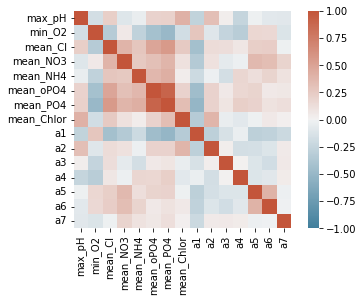

In [44]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap)

The best predictors for the targets in no particular order, according to Pearson's method are:
- a1: mean PO4,mean oPO4, min O2, min NO3 and mean Cl.
- a2: mean Chlor, max pH, mean PO4 and mean oPO4.
- a3: min O2, mean PO4, mean oPO4 and mean NH4.
- a4: min O2, mean PO4, mean oPO4, max pH and mean NH4.
- a5: mean NO3, mean Cl, min O2, mean oPO4, mean PO4.
- a6: min O2, mean Cl, mean NO3 and mean NH4.
- a7: mean NO3, min O2, mean NH4 and mean PO4.
  
Some other interesting observations:
- Mean oPO4 and mean PO4 seem very closely related, it could be worth joining them together into a single column if other correlation models suggest the same relationship.
- Mean Cl and mean Chlor are not as related as it would be expected from two chemically close substances.
- Some targets are good predictors for other targets, namely a5 and a6 are very close, and a1 seems to be a decent predictor for several other targets, including being the best indicator for a7.

We will use another different correlation calculation method now to try and get some more insights.

In [45]:
columns = algae.columns
corr = algae[columns].corr(numeric_only=True,method ="spearman")
corr

,max_pH,min_O2,mean_Cl,mean_NO3,mean_NH4,mean_oPO4,mean_PO4,mean_Chlor,a1,a2,a3,a4,a5,a6,a7
max_pH,1.000000,-0.148528,0.223449,-0.135167,0.029188,0.290314,0.210949,0.436391,-0.247787,0.477671,0.147193,-0.291257,-0.030325,-0.101052,-0.016911
min_O2,-0.148528,1.000000,-0.411707,0.048467,-0.343417,-0.452890,-0.509321,-0.253608,0.278605,-0.182071,-0.299230,-0.390906,0.073907,0.219910,-0.179125
mean_Cl,0.223449,-0.411707,1.000000,0.506317,0.628380,0.696225,0.734528,0.603975,-0.574721,0.366868,0.120044,0.197029,0.394988,0.289839,0.169921
mean_NO3,-0.135167,0.048467,0.506317,1.000000,0.423510,0.436346,0.456540,0.331333,-0.381221,0.136543,-0.003967,0.042548,0.478605,0.465262,0.157976
mean_NH4,0.029188,-0.343417,0.628380,0.423510,1.000000,0.606166,0.647448,0.475315,-0.445737,0.187624,-0.031177,0.303056,0.336292,0.266653,0.250062
mean_oPO4,0.290314,-0.452890,0.696225,0.436346,0.606166,1.000000,0.908126,0.564738,-0.670913,0.391383,0.179791,0.150291,0.308121,0.208877,0.276362
mean_PO4,0.210949,-0.509321,0.734528,0.456540,0.647448,0.908126,1.000000,0.602380,-0.653375,0.363741,0.189811,0.213132,0.309128,0.210717,0.330918
mean_Chlor,0.436391,-0.253608,0.603975,0.331333,0.475315,0.564738,0.602380,1.000000,-0.573321,0.471074,0.024438,0.021867,0.219969,0.203894,0.248047
a1,-0.247787,0.278605,-0.574721,-0.381221,-0.445737,-0.670913,-0.653375,-0.573321,1.000000,-0.277781,-0.138834,-0.061906,-0.326678,-0.305046,-0.272578
a2,0.477671,-0.182071,0.366868,0.136543,0.187624,0.391383,0.363741,0.471074,-0.277781,1.000000,0.263219,-0.271549,-0.055824,-0.070723,0.154525


<Axes: >

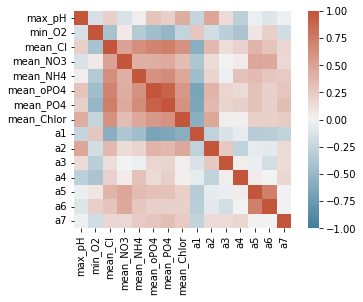

In [46]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap)

The Spearman's Rank Correlation Coefficient seems to have worked better for this dataset than Pearson's Coefficient, showing overall stronger relationships between columns, but besides that the overall correlations remain the same, not revealing anything new.

We will now use Phik Correlation Coefficient, which also analyses categorical columns.

In [47]:
import phik
columns = algae.columns
corr = algae[columns].phik_matrix()
corr

interval columns not set, guessing: ['max_pH', 'min_O2', 'mean_Cl', 'mean_NO3', 'mean_NH4', 'mean_oPO4', 'mean_PO4', 'mean_Chlor', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7']


,Season,Size,Speed,max_pH,min_O2,mean_Cl,mean_NO3,mean_NH4,mean_oPO4,mean_PO4,mean_Chlor,a1,a2,a3,a4,a5,a6,a7
Season,1.000000,0.000000,0.000000,0.000000,0.347767,0.076328,0.000000,0.000000,0.130914,0.000000,0.134510,0.000000,0.235722,0.180030,0.000000,0.000000,0.106586,0.000000
Size,0.000000,1.000000,0.620101,0.655207,0.271610,0.542184,0.288806,0.313134,0.418563,0.484746,0.350571,0.353390,0.301927,0.288757,0.000000,0.288464,0.000000,0.212558
Speed,0.000000,0.620101,1.000000,0.445096,0.438738,0.700282,0.442686,0.237768,0.466857,0.504908,0.515787,0.369374,0.248468,0.064351,0.054338,0.032611,0.000000,0.038857
max_pH,0.000000,0.655207,0.445096,1.000000,0.129955,0.213127,0.000000,0.000000,0.358447,0.212735,0.430192,0.372031,0.231549,0.000000,0.493595,0.000000,0.000000,0.000000
min_O2,0.347767,0.271610,0.438738,0.129955,1.000000,0.404772,0.320067,0.640132,0.582097,0.618977,0.257855,0.000000,0.118330,0.225246,0.293585,0.000000,0.000000,0.000000
mean_Cl,0.076328,0.542184,0.700282,0.213127,0.404772,1.000000,0.368138,0.557592,0.580357,0.601440,0.387742,0.246935,0.323512,0.480350,0.000000,0.213304,0.498527,0.000000
mean_NO3,0.000000,0.288806,0.442686,0.000000,0.320067,0.368138,1.000000,0.687409,0.526661,0.465686,0.405881,0.000000,0.000000,0.000000,0.000000,0.653514,0.486949,0.274779
mean_NH4,0.000000,0.313134,0.237768,0.000000,0.640132,0.557592,0.687409,1.000000,0.718172,0.721508,0.000000,0.000000,0.000000,0.000000,0.431777,0.494679,0.420169,0.275096
mean_oPO4,0.130914,0.418563,0.466857,0.358447,0.582097,0.580357,0.526661,0.718172,1.000000,0.906234,0.587565,0.387230,0.331903,0.270878,0.170881,0.474134,0.187790,0.129291
mean_PO4,0.000000,0.484746,0.504908,0.212735,0.618977,0.601440,0.465686,0.721508,0.906234,1.000000,0.614549,0.395721,0.203166,0.615508,0.275084,0.463542,0.207525,0.298210


<Axes: >

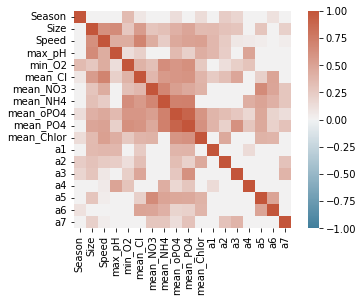

In [48]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap)

With the Phik Coefficient our main focus is looking at which categorical columns were recommended as good indicators for out target and any new relationships shown:
- a1: size and speed
- a2: season, size and speed
- a3: size and season
- a4: none
- a5: size
- a6: None too strong but a weak one to season
- a7: size


There also seems to be a relationship between size and speed but nothing concerning.

The correlation coefficients showed us that some targets can be good indicators for other targets. It might be a good idea to use some targets as features depending on which target we want to predict.

They also showed us that PO4 and oPO4 are very closely related, that is not necessarily bad, but if we are modeling on top of that data it could lead to overrepresentation and our model giving too much importance to those features, to avoid that it would be wise to create a new column with the averaged values of PO4 and oPO4 wich we will do next.

<Axes: xlabel='mean_oPO4', ylabel='Count'>

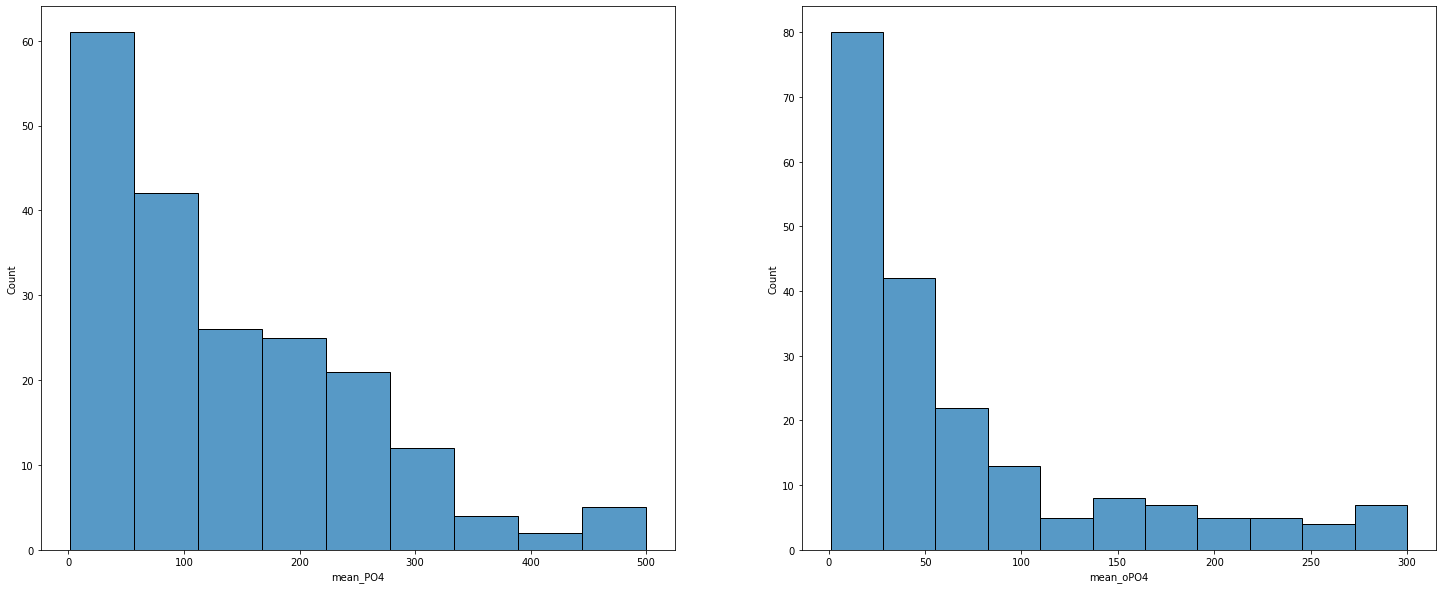

In [49]:
fig, axes = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(data=algae,x="mean_PO4",ax=axes[0])
sns.histplot(data=algae,x="mean_oPO4",ax=axes[1])

As you can see the features are not exactly in the same scale with PO4 varying from 0 to 500 and oPO4 from 0 to 300, so to get a simple representation of the data in one column we will do a wheighed average of 1:2, this should give us a good approximation without being too complex.

In [50]:
averageP =[]

for index,row in algae.iterrows():
    avg = (row["mean_PO4"] + (2*row["mean_oPO4"]))/3
    averageP.append(avg)

algae["averageP"] = averageP

algae[["mean_PO4","mean_oPO4","averageP"]]

,mean_PO4,mean_oPO4,averageP
0,170.00000,105.000,126.666667
1,500.00000,300.000,366.666667
2,187.05701,125.667,146.130337
3,138.70000,61.182,87.021333
4,97.58000,58.222,71.341333
...,...,...,...
194,61.44400,19.111,33.222000
195,79.75000,53.625,62.333333
196,75.90400,35.333,48.856667
197,140.22000,78.333,98.962000


Now we have a column that contains just the averaged-out value of both linked Features, it would be preferable to use this column to train any models, since it would retain the relationship to the target and would not cause our model to overvalue the original features.

In conclusion, which features are the most important differ from target to target, and it would be wise to look at the correlation matrices and the generated views before picking the ones to use for modeling or prediction and in some cases using some other targets as features could also be a good idea since some of them have good correlation coefficients to each other.

If this data is to be used for the training of a machine learning model, I would recommend using the averageP feature just generated instead of either mean PO4 or mean oPO4 to avoid the previously mentioned problems.